In [1]:
#!pip install impyute
#pip install ipywidgets
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
#!pip install Pipeline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import time
import random
import numpy as np
from numpy import quantile, where
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import missingno as msno
import itertools
from pandas_profiling import ProfileReport
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.impute import SimpleImputer
from  sklearn.neighbors import LocalOutlierFactor
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from impyute.imputation.cs import fast_knn, mice
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.blackbox import LimeTabular
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp
from imblearn.over_sampling import SMOTE, SMOTENC
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

import sys
sys.path.append('../..')

from utils.use_regression import (create_dummy_vars, create_formula, run_regression, calculate_vif, 
                                  calcuate_confusion_matrix, convert_results_to_df)

### 1. Import Data

In [4]:
hmda_file = '../../data/hmda_lar/cleaned_data/2_analysis_hmda_stage2.csv'


hmda_df = pd.read_csv(hmda_file) 

hmda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98832 entries, 0 to 98831
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   loan_amount                        98832 non-null  float64
 1   combined_loan_to_value_ratio       98832 non-null  float64
 2   loan_term                          98832 non-null  float64
 3   property_value                     98832 non-null  float64
 4   income                             98832 non-null  float64
 5   debt_to_income_ratio               98832 non-null  float64
 6   tract_population                   98832 non-null  float64
 7   tract_minority_population_percent  98832 non-null  float64
 8   ffiec_msa_md_median_family_income  98832 non-null  float64
 9   tract_to_msa_income_percentage     98832 non-null  float64
 10  tract_one_to_four_family_homes     98832 non-null  float64
 11  tract_median_age_of_housing_units  98832 non-null  flo

#####################################################3

In [5]:

Categorical = pd.DataFrame(hmda_df.apply(pd.Series.nunique))
Categorical.reset_index(inplace=True)

In [6]:
for dd in range(0,len(Categorical)):
    if Categorical.iloc[dd,1]<15 and Categorical.iloc[dd,0]!='loan_outcome': # defined that if a variable with less than 15 categories are categorical
        cat = Categorical.iloc[dd,0]
        hmda_df[cat]= hmda_df[cat].astype('category')

In [7]:
hmda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3338872 entries, 0 to 3338871
Data columns (total 42 columns):
 #   Column                             Dtype   
---  ------                             -----   
 0   loan_amount                        float64 
 1   combined_loan_to_value_ratio       float64 
 2   loan_term                          float64 
 3   property_value                     float64 
 4   income                             float64 
 5   debt_to_income_ratio               float64 
 6   tract_population                   int64   
 7   tract_minority_population_percent  float64 
 8   ffiec_msa_md_median_family_income  int64   
 9   tract_to_msa_income_percentage     float64 
 10  tract_one_to_four_family_homes     int64   
 11  tract_median_age_of_housing_units  int64   
 12  loan_outcome                       int64   
 13  Nonconforming                      category
 14  Undetermined                       category
 15  gov_sponsored_loan_pchase          category
 16  

In [8]:
profile = ProfileReport(hmda_df, minimal=True)
profile.to_file(output_file="output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\multimethod\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Feature selection for do One-Hot-Encoding

In [9]:
one_hot_cols = [                   
                   ### reference: Conforming
                   {'conforming_loan_limit': {'Nonconforming': [2], 'Undetermined': [3]}},

                   ### reference: no cover loan purchase
                   {'purchaser_type': {'gov_sponsored_loan_pchase': [1, 2, 3, 4],
                                       'banks_mtg_loan_pchase':[6, 71], 'othr_loan_pchase':[72, 8, 9]}},
                   
                   
                    ### Reference: No_Coapplicant
                   {'coapp_race_ethnicity': {'coapp_white': [5], 'coapp_black': [3], 'coapp_latino': [6], 'coapp_asian': [2], 'coapp_native': [1],
                                             'coapp_pac_islander': [4]
                                             }}, #using a different column to determine whether a co-applicant participated in the loan

                    ### Reference: Coapplicant
                   {'co_applicant_sex': { 'coapp_female': [2]}}, #using a different column to determine whether a co-applicant participat 'coapp_male': [1],

                   ### reference: other loan purposes
                   #{'loan_purpose': {'home_purchase': [1], 'home_improve_ppose': [2], 'refinancing_ppose':[31, 32]
                                     #, 'othr_ppose':[4, 5] }},
                   
                    ### reference: Secured by a first lien
                   {'lien_status': {'subord_lien_loan_sec': [2]}},                                                         

                   ### Reference:   Not an open-end line of credit
                   {'open_end_line_of_credit': {'open_end_line_credit': [1]}},
                   
                   ### Reference: High-cost mortgage
                   #{'hoepa_status': {'not_high_cost_mtgage': [2]}},                   

                   ### Reference: no reference
                   {'applicant_credit_score_type': {'FICO_credit_check': [1, 2, 3], 'vantage_credit_check': [6], 
                                           'other_credit_check': [5, 6]}},
                   
                   {'co_applicant_credit_score_type': {'coapp_FICO_credit_check': [1, 2, 3], 'coapp_vantage_credit_check': [6],
                                                       'coapp_other_credit_check': [5, 6]}},
                   
                   ### Reference: Not used AUS underwriting
                   {'aus_1': {'DU_aus': [1], 'LP_aus': [2], 'tech_open_aus': [3], 
                              'other_aus': [4, 5, 6, 7]}},                   

                   ### Reference: White
                   {'app_race_ethnicity': {'black': [3], 'latino': [6], 'asian': [2], 'native': [1],
                                           'pac_islander': [4]}},  # 'race_na': [7], 'pac_islander': [4], 'white': [5],
                                      
                   ### Reference: Male
                   {'applicant_sex': { 'female': [2]}}, #, 'sex_na': [3, 6], 'male':[1],
                   

]


In [10]:
ohe_cols = []
for columns in one_hot_cols:
    ### Function to create dummy variables
    hmda_df, ohe_cols = create_dummy_vars(hmda_df, columns, ohe_cols)
    

In [11]:
hmda_df = hmda_df.select_dtypes(exclude=['category'])

In [12]:
#setting features as categorical
for dd in ohe_cols:
        hmda_df[dd]= hmda_df[dd].astype('category')
hmda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3867978 entries, 0 to 3867977
Data columns (total 44 columns):
 #   Column                             Dtype   
---  ------                             -----   
 0   loan_amount                        int64   
 1   combined_loan_to_value_ratio       float64 
 2   loan_term                          float64 
 3   property_value                     float64 
 4   income                             float64 
 5   debt_to_income_ratio               float64 
 6   tract_population                   int64   
 7   tract_minority_population_percent  float64 
 8   ffiec_msa_md_median_family_income  int64   
 9   tract_to_msa_income_percentage     float64 
 10  tract_owner_occupied_units         int64   
 11  tract_one_to_four_family_homes     int64   
 12  tract_median_age_of_housing_units  int64   
 13  loan_outcome                       int64   
 14  Nonconforming                      category
 15  Undetermined                       category
 16  

In [13]:
""" profile = ProfileReport(hmda_df, minimal=True)
profile.to_file(output_file="output.html") """

' profile = ProfileReport(hmda_df, minimal=True)\nprofile.to_file(output_file="output.html") '

In [14]:
#msno.bar(hmda_df)

### Analyzing, Detecting and Cleaning Outliers

In [15]:
hmda_df.describe()

loan_amount  combined_loan_to_value_ratio     loan_term  \
count  3.867978e+06                  3.527019e+06  3.765884e+06   
mean   3.339267e+05                  2.343031e+02  3.374085e+02   
std    8.459874e+05                  1.174432e+05  6.137480e+01   
min    5.000000e+03                  1.000000e-03  1.000000e+00   
25%    1.550000e+05                  7.562100e+01  3.600000e+02   
50%    2.650000e+05                  8.000000e+01  3.600000e+02   
75%    4.150000e+05                  9.500000e+01  3.600000e+02   
max    1.409715e+09                  1.099700e+08  3.690000e+03   

       property_value        income  debt_to_income_ratio  tract_population  \
count    3.726702e+06  3.806071e+06          3.709877e+06      3.867978e+06   
mean     4.500381e+05  1.527083e+02          3.603819e+01      5.584771e+03   
std      9.594458e+05  9.101798e+03          1.035135e+01      3.351337e+03   
min      5.000000e+03 -3.590040e+05          2.000000e+01      0.000000e+00   
25%      2.150000e+05  6.000000e+01          2.500000e+01      3.692000e+03   
50%      3.450000e+05  9.600000e+01          3.600000e+01      5.055000e+03   
75%      5.350000e+05  1.550000e+02          4.300000e+01      6.718000e+03   
max      1.410005e+09  1.200024e+07          6.500000e+01      5.381200e+04   

       tract_minority_population_percent  ffiec_msa_md_median_family_income  \
count                       3.867978e+06                       3.867978e+06   
mean                        2.916868e+01                       8.155320e+04   
std                         2.409645e+01                       1.972063e+04   
min                         0.000000e+00                       0.000000e+00   
25%                         1.041000e+01                       7.060000e+04   
50%                         2.187000e+01                       7.970000e+04   
75%                         4.175000e+01                       8.930000e+04   
max                         1.000000e+02                       1.630000e+05   

       tract_to_msa_income_percentage  tract_owner_occupied_units  \
count                    3.867978e+06                3.867978e+06   
mean                     1.140501e+02                1.457457e+03   
std                      4.542544e+01                9.546738e+02   
min                      0.000000e+00                0.000000e+00   
25%                      8.700000e+01                9.020000e+02   
50%                      1.090000e+02                1.318000e+03   
75%                      1.360000e+02                1.812000e+03   
max                      5.070000e+02                1.952900e+04   

       tract_one_to_four_family_homes  tract_median_age_of_housing_units  \
count                    3.867978e+06                       3.867978e+06   
mean                     1.994954e+03                       3.444883e+01   
std                      1.209501e+03                       1.815644e+01   
min                      0.000000e+00                      -1.000000e+00   
25%                      1.306000e+03                       2.100000e+01   
50%                      1.813000e+03                       3.200000e+01   
75%                      2.450000e+03                       4.600000e+01   
max                      2.539100e+04                       7.600000e+01   

       loan_outcome  
count  3.867978e+06  
mean   8.768936e-01  
std    3.285594e-01  
min    0.000000e+00  
25%    1.000000e+00  
50%    1.000000e+00  
75%    1.000000e+00  
max    1.000000e+00

based on column by column analysis it feels better to remove outliers on a column basis

In [16]:
def data_clean(df, col, high, low):
    df[col] = np.where(df[col]>high , np.nan, df[col])
    df[col] = np.where(df[col]<low , np.nan, df[col]) # None of the columns are supposed to have negative values
    #return df

In [17]:
# loan amount

An analysis of property value and combined loan to value rate indicate >100M dolar homes as valid data. However, we'll consider loans > 100M as outliers. there are 8,000 loans wich the loan is less than $8,000 but we're not considering them as outliers at this point.

In [18]:
hmda_df[hmda_df['loan_amount']>1.000005e+08]

loan_amount  combined_loan_to_value_ratio  loan_term  property_value  \
98379     613605000                           NaN        NaN             NaN   
559437   1409715000                         99.98        NaN    1.410005e+09   

        income  debt_to_income_ratio  tract_population  \
98379   1196.0                   NaN              3741   
559437   153.0                  41.0              3591   

        tract_minority_population_percent  ffiec_msa_md_median_family_income  \
98379                               19.99                              98900   
559437                              19.60                              85500   

        tract_to_msa_income_percentage  ...  DU_aus  LP_aus  tech_open_aus  \
98379                            316.0  ...     1.0     1.0            1.0   
559437                            80.0  ...     1.0     1.0            1.0   

        other_aus black latino asian native pac_islander female  
98379         1.0   1.0    1.0   1.0    1.0          1.0    1.0  
559437        0.0   1.0    1.0   1.0    1.0          1.0    1.0  

[2 rows x 44 columns]

In [19]:
data_clean(hmda_df, 'loan_amount', 100000000, 0)

Combined Loan to value rate is a number between 0-100%

In [20]:
data_clean(hmda_df, 'combined_loan_to_value_ratio', 100, 0)

Loan terms <6 months or >40 years appear to be outliers

In [21]:
data_clean(hmda_df, 'loan_term', 481, 6)

According to Forbes (https://www.forbes.com/sites/emmareynolds/2022/01/27/the-one-in-la-could-become-the-most-expensive-home-ever-sold-in-the-us-at-295-million/?sh=54aa0e7217d6) the most expensive home in the US was listed for $295M dollars, therefore we'll consider this as the threshold for outliers.


In [22]:
data_clean(hmda_df, 'property_value', 296e+8, 0)



negative income is considered as an outlier

In [23]:
data_clean(hmda_df, 'property_value', 10e+6, 0)

Getting the final view on NA values

In [24]:
amv=hmda_df.groupby(by='loan_outcome', as_index=False).count().T #.melt(id_vars='loan_outcome')


<Figure size 500x300 with 0 Axes>

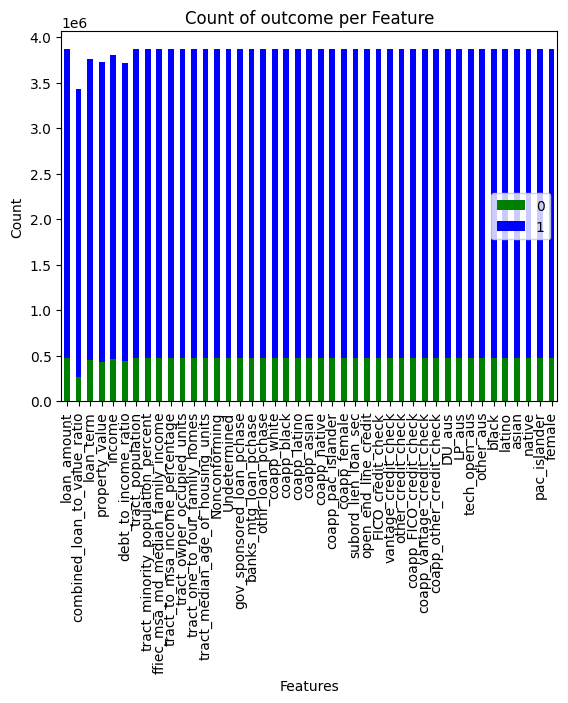

In [25]:
plt.figure(figsize=(5,3))
amv.drop('loan_outcome').plot(kind='bar', stacked=True, color=['green', 'blue'])
# Add Title and Labels
plt.title('Count of outcome per Feature')
plt.xlabel('Features')
plt.ylabel('Count')
plt.legend(loc='right')


### Dealing with NA values

There are many distinct ways of dealing with NA values.

For one, we could have used MICE (Multivariate Imputation) Method https://www.jstatsoft.org/article/view/v045i03 Or we could've used Fast KNN https://impyute.readthedocs.io/en/master/_modules/impyute/imputation/cs/fast_knn.html

Both were tested and given the size of the dataset, MICE didn't converge and Fast KNN was taking too long to process.

Finally, since the dataset has millions of lines, we decided that dropping these lines were not detrimental to the final results

In [26]:
def mice_na_fill(df):

  imputed_training=mice(df.to_numpy(), vis = "monotone", meth = "pmm")
  changed_df= pd.DataFrame(data=imputed_training,columns=df.columns)
  return changed_df

In [27]:
def fastknn_na_fill(df):
  sys.setrecursionlimit(100000)
  imputed_training=fast_knn(df.to_numpy(), k=10)
  changed_df= pd.DataFrame(data=imputed_training,columns=df.columns)
  return changed_df

In [28]:
################
## Not in use ##
################
#X_train = fastknn_na_fill(X_train)


#X_test = X_test.reset_index().dropna()
#X_test.shape
#y_test = y_test.loc[y_test.index.isin(X_test['index'])]

#X_test.drop('index',axis=1, inplace=True) #dropping the added index
#y_test.shape
#y_test.reset_index(drop=True, inplace=True)

In [29]:
################
## Not in use ##
################

  #sys.setrecursionlimit(100000)
  #X_test=fast_knn(X_test, k=10)
  
  #y_train = pd.Series(y_train.to_numpy(), name=y_train.name) #resetting the index for the y_train

In [30]:
#removing the rows containing missing neighbors
hmda_df.dropna(inplace=True)

### Finding Data correlation and Multicollinearity

In [31]:
df_corr = hmda_df.copy() # this is used to be able to correlate categorical features
for cc in ohe_cols:
        df_corr[cc]= df_corr[cc].astype('bool')

Since the Pearson correlation can evaluate only a linear relationship between two continuous variables, we decided Spearman’s rank correlation coefficient. Spearman is a nonparametric measure of rank correlation (statistical dependence between the rankings of two variables). It assesses how well the relationship between two variables can be described using a monotonic function. The Spearman correlation can evaluate a monotonic relationship between two variables — Continous or Ordinal and it is based on the ranked values for each variable rather than the raw data.

In [32]:
def correlationMatrix(pandas,target=False, method_type='spearman'):
  if target==True:
    correlation_matrix=pandas.corr(method=method_type)
  else:
    pandas = pandas.drop("loan_outcome", axis=1)
    correlation_matrix=pandas.corr(method=method_type)
  return correlation_matrix


def heatMap(corr_matrix,target=False):
  
  if target==True:
    plt.figure(figsize=(8, 6))
    heat = sns.heatmap(corr_matrix[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True)
    
  else:
    plt.figure(figsize=(20, 12))
    heat = sns.heatmap(corr_matrix, vmin=-1, vmax=1,center=0,cmap=sns.diverging_palette(20, 220, n=8),square=True)
  heat.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12)
  heat.set_xticklabels(heat.get_xticklabels(), rotation=90,
                       fontsize=8, horizontalalignment='right')
  heat.set_yticklabels(heat.get_yticklabels(),rotation=0,fontsize=8)

In [33]:
#CM=correlationMatrix(df_corr,False)

In [34]:
#plotting the heatmap
#heatMap(CM)

In [35]:
from sklearn.linear_model import LinearRegression
def calculate_vif(df, features):    
    gvif, vif, tolerance = {}, {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
        gvif[feature] = sqrt(vif[feature])
    # return VIF DataFrame
    return pd.DataFrame({'GVIF': gvif, 'VIF': vif, 'Tolerance': tolerance})

Investigating Multicollinearity with method known as GVIF and VIF — General Variance Inflation Factor.

In [36]:
#calculate_vif(hmda_df, hmda_df.drop(['loan_outcome'], axis=1).columns).sort_values(by='VIF', ascending=False).head(15)


Removing some highly collinear variables

In [37]:
#calculate_vif(hmda_df, hmda_df.drop(['loan_outcome', 'other_aus', 'tract_owner_occupied_units'], axis=1).columns).sort_values(by='VIF', ascending=False).head(15)


In [38]:
#removing Highly collinear columns
hmda_df.drop([ 'other_aus', 'tract_owner_occupied_units'], axis=1, inplace=True)

Verifying the correlation of every variable against the target Loan outcome

In [39]:
hmda_df.drop("loan_outcome", axis=1).apply(lambda x: x.corr(hmda_df.loan_outcome)).sort_values(ascending=True)

gov_sponsored_loan_pchase           -0.269852
debt_to_income_ratio                -0.227681
banks_mtg_loan_pchase               -0.133026
DU_aus                              -0.089570
LP_aus                              -0.073082
othr_loan_pchase                    -0.062794
coapp_white                         -0.061130
coapp_female                        -0.038712
tract_minority_population_percent   -0.036524
FICO_credit_check                   -0.035913
coapp_FICO_credit_check             -0.035853
combined_loan_to_value_ratio        -0.013142
income                              -0.002163
coapp_other_credit_check            -0.001128
coapp_asian                         -0.000686
coapp_pac_islander                   0.001617
coapp_vantage_credit_check           0.002021
coapp_native                         0.002911
pac_islander                         0.003735
asian                                0.006006
female                               0.009237
Nonconforming                     

there is a high correlation between not_high_cost_mtgage, gov_sponsored_loan_pchase and the loan_outcome

### Initiating model testing with the split of Train and test datasets

In [40]:

X=hmda_df.drop('loan_outcome', axis=1)
y=hmda_df['loan_outcome']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1, stratify=y)


### Anomaly value investigation

(Not in use)
Besides outliers, we're going to investigate the dataset for Abnormal values

In [41]:
""" lof_outlier = LocalOutlierFactor(n_neighbors=20, novelty=False)

lof_outlier.fit_predict(X_train) ###############################note: might need to Normalize the data!!!!

prediction_outlier = lof_outlier.negative_outlier_factor_

prediction_outlier """


' lof_outlier = LocalOutlierFactor(n_neighbors=20, novelty=False)\n\nlof_outlier.fit_predict(X_train) ###############################note: might need to Normalize the data!!!!\n\nprediction_outlier = lof_outlier.negative_outlier_factor_\n\nprediction_outlier '

In [42]:
#prediction_outlier = lof_outlier.negative_outlier_factor_

In [43]:
#thresh = quantile(prediction_outlier,.01) #Eliminating the 1% abnormal numbers
#print(thresh)

In [44]:
#index = where(prediction_outlier<=thresh)
#index = pd.DataFrame(index)
#index

In [45]:
#print(X_train.loc[~X_train.index.isin(index)].shape)
#print(y_train.loc[~y_train.index.isin(index)].shape)

In [46]:
#X_train = X_train.loc[~X_train.index.isin(index)]
#y_train = y_train.loc[~y_train.index.isin(index)]

### Handling Data inbalance

Approved Loans: 2473435
Denied Loans: 197662
Proportion: 12.51 : 1


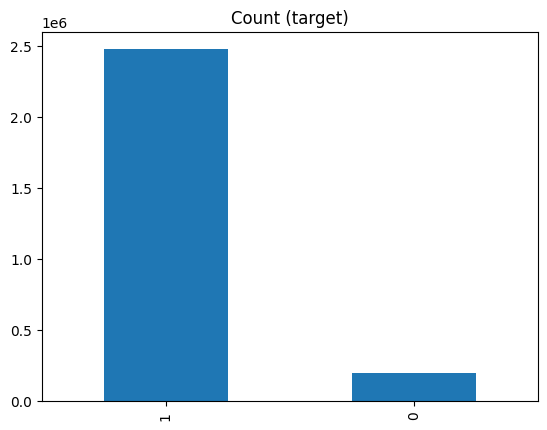

In [47]:
target_count = y_train.value_counts()
print('Approved Loans:', target_count[1])
print('Denied Loans:', target_count[0])
print('Proportion:', round(target_count[1] / target_count[0], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Undersampling Majority Class (approved loans)

In [48]:


def sample_together(n, X, y):
    rows = random.sample(np.arange(0,len(X.index)).tolist(),n)
    return X.iloc[rows,], y.iloc[rows,]

def undersample_majority(X, y, under = 0):
    y_min = y[y == under]
    y_max = y[y != under]
    X_min = X.filter(y_min.index,axis = 0)
    X_max = X.filter(y_max.index,axis = 0)

    X_under, y_under = sample_together(len(y_min.index), X_max, y_max)
    
    X = pd.concat([X_under, X_min])
    y = pd.concat([y_under, y_min])
    return X, y



def resample(X, y, fraction=0.1):
    X = X.sample(frac=fraction)
    
    y = y.loc[y.index.isin(X.index)]
    print(X.shape, y.shape)
    return X, y

#X_test = X_test.reset_index().dropna()
#X_test.shape
#y_test = y_test.loc[y_test.index.isin(X_test['index'])]

#X_test.drop('index',axis=1, inplace=True) #dropping the added index
#y_test.shape
#y_test.reset_index(drop=True, inplace=True)


In [49]:
#X_test = X_test.reset_index().dropna()
#X_test.shape
#y_test = y_test.loc[y_test.index.isin(X_test['index'])]

#X_test.drop('index',axis=1, inplace=True) #dropping the added index
#y_test.shape
#y_test.reset_index(drop=True, inplace=True)

In [50]:
X_train_bal, y_train_bal = undersample_majority(X_train, y_train)
X_test_bal, y_test_bal = undersample_majority(X_test, y_test)



In [51]:
print(y_train_bal.value_counts())
print(y_test_bal.value_counts())

1    197662
0    197662
Name: loan_outcome, dtype: int64
1    49416
0    49416
Name: loan_outcome, dtype: int64


SMOTENC (Not in use)

In [52]:
def DF_cat_list(df):
    list = []
    for i in range(0,len(df.dtypes)):
        if df.dtypes[i] == "category":
            list.append(i)
    return list    

def smote_resampling(X,y):
    cat_feat_index = DF_cat_list(X)
    smote = SMOTENC(categorical_features= cat_feat_index, random_state=1)
    X_smote, y_smote = smote.fit_resample(X, y)
    return X_smote, y_smote


#CategoricalDtype(categories=[0.0, 1.0], ordered=False)

In [53]:
#Not using SMOTE
#X_sm, y_sm = smote_resampling(X_train,y_train)
#X_sm_test, y_sm_test = smote_resampling(X_test,y_test)

Standarizing features by removing the mean and stardarizing the variance

In [54]:
def standarizer(a):

  scaler = StandardScaler()
  scaler=scaler.fit_transform(a)
  return scaler

def normalizer(a):

  scaler = MinMaxScaler()
  scaler=scaler.fit_transform(a)
  return scaler

In [55]:
continuous_cols = X_train.select_dtypes(exclude=['category']).columns
categorical_cols = X_train.select_dtypes(include=['category']).columns

In [56]:
print('Continuous feature columns are: ' + f'{continuous_cols}')
print('Categorical feature columns are: ' + f'{categorical_cols}')


Continuous feature columns are: Index(['loan_amount', 'combined_loan_to_value_ratio', 'loan_term',
       'property_value', 'income', 'debt_to_income_ratio', 'tract_population',
       'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'tract_one_to_four_family_homes', 'tract_median_age_of_housing_units'],
      dtype='object')
Categorical feature columns are: Index(['Nonconforming', 'Undetermined', 'gov_sponsored_loan_pchase',
       'banks_mtg_loan_pchase', 'othr_loan_pchase', 'coapp_white',
       'coapp_black', 'coapp_latino', 'coapp_asian', 'coapp_native',
       'coapp_pac_islander', 'coapp_female', 'subord_lien_loan_sec',
       'open_end_line_credit', 'FICO_credit_check', 'vantage_credit_check',
       'other_credit_check', 'coapp_FICO_credit_check',
       'coapp_vantage_credit_check', 'coapp_other_credit_check', 'DU_aus',
       'LP_aus', 'tech_open_aus', 'black', 'latino', 'asian', 'native',
       'pac_i

Applying the dataframeMapper to transform only the continuous columns in the Dataframe

In [57]:
mapper = DataFrameMapper(
    [([continuous_col], StandardScaler()) for continuous_col in continuous_cols] +
    [([categorical_col], None) for categorical_col in categorical_cols]
    ,df_out=True
    )



In [58]:
X_train_std = mapper.fit_transform(X_train_bal)
X_test_std = mapper.fit_transform(X_test_bal)

In [59]:
X_train_GS, y_train_GS = resample(X_train_std, y_train_bal, fraction=0.04)
print(y_train_GS.value_counts())


(15813, 41) (15813,)
0    7913
1    7900
Name: loan_outcome, dtype: int64


### Model Parameter Optimization

Since we'll be using some blackbox models, we'll attempt to optimize their parameters

In [60]:
model_params = {
    'MLP': {
        'model': MLPClassifier(),
        'params' : {
            'hidden_layer_sizes' : [(1500,3)],
            'alpha': np.geomspace(1e-6,1e-3, 15, endpoint = True),
            'learning_rate_init': np.geomspace(1e-5,1e-3, 15, endpoint = True),
            'max_iter':np.linspace(500,1500,num=5, dtype=int),
            'verbose':[False]
            }
        },
    'RandForrest': {
        'model': RandomForestClassifier(),
        'params' : {
            'bootstrap': [True],
            "n_estimators": np.linspace(100,1000,num=10, dtype=int),
            "max_depth": [80,90,100,None],
            #"criterion":["gini"],
            "min_samples_split": [2,4,8],
            "min_samples_leaf": [1,2,3,4,5]
            #"class_weight":["balanced","balanced_subsample",None]   
            }
        },
    
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    }
}

In [61]:
""" 
scores = []

for model_name, mp in model_params.items():
    clf =  RandomizedSearchCV(mp['model'], mp['params'], n_iter=20, cv=5, return_train_score=False)
    clf.fit(X_train_GS, y_train_GS)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
model_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
model_df """

" \nscores = []\n\nfor model_name, mp in model_params.items():\n    clf =  RandomizedSearchCV(mp['model'], mp['params'], n_iter=20, cv=5, return_train_score=False)\n    clf.fit(X_train_GS, y_train_GS)\n    scores.append({\n        'model': model_name,\n        'best_score': clf.best_score_,\n        'best_params': clf.best_params_\n    })\n    \nmodel_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])\nmodel_df "

In [62]:
#model_df.to_csv('../../notebooks/model_param_optimization.csv', index = False)

In [63]:
# Calculating accuracy, F1-score views
def metrics(y_pred, y_true, model_name=None):
  report = classification_report(y_true, y_pred, output_dict=True)
  df = pd.DataFrame(report).transpose()
  df2 = df.reset_index().melt('index')
  df2['index0'] = df2['variable'].astype('str') +'_'+ df2['index'].astype('str')
  df2 = df2.pivot_table(values='value', columns='index0', aggfunc='first').reset_index(drop=True)
  df2.insert(loc=0, column='model', value=model_name)
  return df2


Copying the best parameters from Randon Search into the models below

In [64]:

def step_func(x):
    if x > 0.5:
        return 1
    else:
        return 0

def DecisionT(X_train, y_train,X_test,y_test, model_name='Decision Tree'):

  deCls=DecisionTreeClassifier(max_depth=15,max_features=5,min_samples_leaf=2,min_samples_split=5, random_state=1)
  deCls.fit(X_train, y_train)
  predictions = deCls.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return deCls, df

def LogRegre(X_train, y_train,X_test,y_test, model_name='Log Regression'):

  logReg = LogisticRegression(solver="saga", tol=1e-3, random_state=1)
  logReg.fit(X_train, y_train)
  predictions = logReg.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return logReg, df
  

def RandFor(X_train, y_train,X_test,y_test, model_name='Random Forest'):

  randF = RandomForestClassifier(bootstrap=True, max_depth=80, min_samples_leaf=2,
                                 min_samples_split=8, n_estimators=200, random_state=1)
  randF.fit(X_train, y_train)
  predictions = randF.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return randF, df

def kNeighbors(X_train, y_train,X_test,y_test, model_name='KNN'):

  kN = KNeighborsClassifier(
      n_neighbors=161, p=2, weights="distance", metric="manhattan", random_state=1)
  kN.fit(X_train, y_train)
  predictions = kN.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return kN, df

def support_vector(X_train, y_train,X_test,y_test, model_name='SVC'):

  sv = SVC(kernel='linear', C=10)
  sv.fit(X_train, y_train)
  predictions = sv.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return sv, df

def mlp(X_train, y_train,X_test,y_test, model_name='MLP'):

  ml = MLPClassifier(alpha=0.001, hidden_layer_sizes=(
      1500, 3), learning_rate_init=3.727593720314938e-05, max_iter=1000, verbose=False, random_state=1)
  ml.fit(X_train, y_train)
  predictions = ml.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return ml, df

def ebm(X_train, y_train,X_test,y_test,feat_names=None,feat_dtypes=None, model_name='Explainable Boosting'):

  eb = ExplainableBoostingClassifier(feature_names= feat_names, feature_types=feat_dtypes, random_state=1)
  eb.fit(X_train, y_train)
  predictions = eb.predict(X_test)
  df = metrics(predictions,y_test, model_name)
  return eb, df

def stats_logit(X_train, y_train,X_test,y_test, model_name='Stats Logistics'):

  log = sm.Logit(y_train, X_train, random_state=1).fit()
  predictions = log.predict(X_test)
  predictions = np.vectorize(step_func)(predictions)
  df = metrics(predictions,y_test, model_name)
  return log, df



We'll take as a next step, a Decision tree, a Logistic Regression, the previously optimized Random Forest and MLP and add the Explainable Boosting Machine

In [65]:
print("Classification Report Decision Tree", flush=True)
model_DT, DT_results = DecisionT(X_train_std, y_train_bal,X_test_std,y_test_bal, model_name='Decision Tree')
print("_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+", flush=True)

print("Classification Report Logistics Reg", flush=True)
model_LR, LR_results = stats_logit(X_train_std, y_train_bal,X_test_std,y_test_bal, model_name='Logistic Regression')
print("_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+", flush=True)
 
print("Classification Report Random Forest", flush=True)
model_RF, RF_results = RandFor(X_train_std, y_train_bal,X_test_std,y_test_bal, model_name='Random Forest')
print("_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+", flush=True)


print("Classification Report EBM", flush=True)
model_EB, EB_results = ebm(X_train_std, y_train_bal,X_test_std,y_test_bal,X.columns, model_name='EBM')
print("_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+", flush=True)


print("Classification Report MLP", flush=True)
model_ML, ML_results = mlp(X_train_std, y_train_bal,X_test_std,y_test_bal, model_name='MLP')
print("_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+", flush=True)



Classification Report Decision Tree
_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+
Classification Report Logistics Reg


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.264275
         Iterations 13
_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+
Classification Report Random Forest
_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+
Classification Report EBM
_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+
Classification Report MLP
_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+


### exporting the models to file

In [66]:
import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


In [69]:
i='model_DT'
exec('model=' + i)
model

DecisionTreeClassifier(max_depth=15, max_features=5, min_samples_leaf=2,
                       min_samples_split=5, random_state=1)

In [70]:
import pickle

models = ['model_DT', 'model_LR', 'model_RF', 'model_EB', 'model_ML'
         ]
ID= '_1121'
for i in models:
    exec('model=' + i)
    filename = '../../notebooks/' + i + ID + '.sav'
    pickle.dump(model, open(filename, 'wb'))


### Plotting and saving results

In [71]:
results=[DT_results, LR_results, RF_results, EB_results, ML_results
         ]
results_df = pd.DataFrame(columns=DT_results.columns)
for i in results:
    results_df = results_df.append(i, ignore_index=True)
results_df.to_csv('../../notebooks/model_results.csv', index = False)
results_df.sort_values(by='f1-score_accuracy', ascending=False)


C:\Users\danie\AppData\Local\Temp\ipykernel_3988\1399997037.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(i, ignore_index=True)


index0                model  f1-score_0  f1-score_1  f1-score_accuracy  \
3                       EBM    0.898276    0.879065           0.889499   
2             Random Forest    0.898332    0.878035           0.889105   
1       Logistic Regression    0.893522    0.869028           0.882538   
4                       MLP    0.880625    0.871180           0.876083   
0             Decision Tree    0.820234    0.754920           0.792598   

index0  f1-score_macro avg  f1-score_weighted avg  precision_0  precision_1  \
3                 0.888671               0.888671     0.832180     0.970726   
2                 0.888184               0.888184     0.829326     0.975399   
1                 0.881275               0.881275     0.817114     0.981974   
4                 0.875903               0.875903     0.849484     0.907064   
0                 0.787577               0.787577     0.723789     0.922506   

index0  precision_accuracy  precision_macro avg  ...  recall_0  recall_1  \
3                 0.889499             0.901453  ...  0.975777  0.803222   
2                 0.889105             0.902362  ...  0.979865  0.798345   
1                 0.882538             0.899544  ...  0.985693  0.779383   
4                 0.876083             0.878274  ...  0.914137  0.838028   
0                 0.792598             0.823147  ...  0.946333  0.638862   

index0  recall_accuracy  recall_macro avg  recall_weighted avg  support_0  \
3              0.889499          0.889499             0.889499    49416.0   
2              0.889105          0.889105             0.889105    49416.0   
1              0.882538          0.882538             0.882538    49416.0   
4              0.876083          0.876083             0.876083    49416.0   
0              0.792598          0.792598             0.792598    49416.0   

index0  support_1  support_accuracy  support_macro avg  support_weighted avg  
3         49416.0          0.889499            98832.0               98832.0  
2         49416.0          0.889105            98832.0               98832.0  
1         49416.0          0.882538            98832.0               98832.0  
4         49416.0          0.876083            98832.0               98832.0  
0         49416.0          0.792598            98832.0               98832.0  

[5 rows x 21 columns]

In [72]:
hmda_df.to_csv(
    '../../data/hmda_lar/cleaned_data/2_analysis_hmda_stage2.csv', index=False)


### Decision Tree analysis

feature importance

In [ ]:
#creating a dictionary of features and their importance values
feat_dict= {}
for col, val in sorted(zip(X_train.columns, model_DT.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

In [ ]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})


In [ ]:
feat_df.head(20)

Feature  Importance
0           gov_sponsored_loan_pchase    0.332424
1                debt_to_income_ratio    0.282845
2               banks_mtg_loan_pchase    0.119006
3                              DU_aus    0.049810
4                         loan_amount    0.039665
5                    othr_loan_pchase    0.037471
6                         coapp_white    0.018627
7                      property_value    0.015289
8                              LP_aus    0.013416
9   ffiec_msa_md_median_family_income    0.010972
10       combined_loan_to_value_ratio    0.010756
11     tract_to_msa_income_percentage    0.009699
12  tract_median_age_of_housing_units    0.007519
13  tract_minority_population_percent    0.006371
14                             income    0.006294
15                 other_credit_check    0.005986
16     tract_one_to_four_family_homes    0.005866
17               subord_lien_loan_sec    0.004805
18                      Nonconforming    0.003359
19                  FICO_credit_check    0.003352

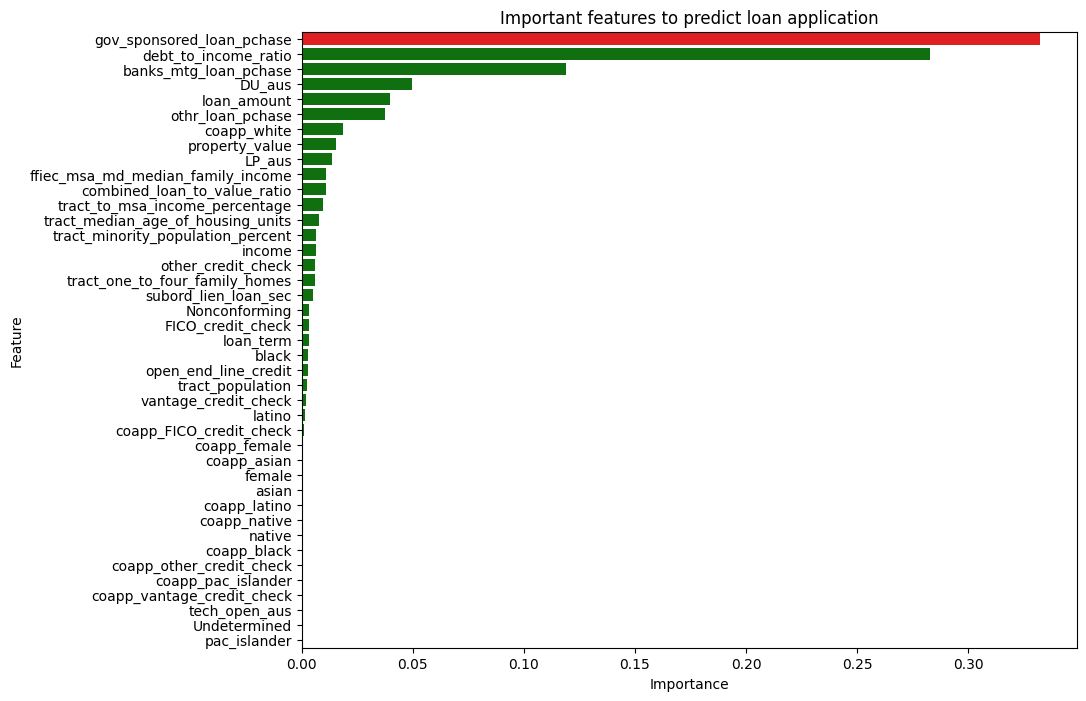

In [ ]:
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict loan application')
plt.show()

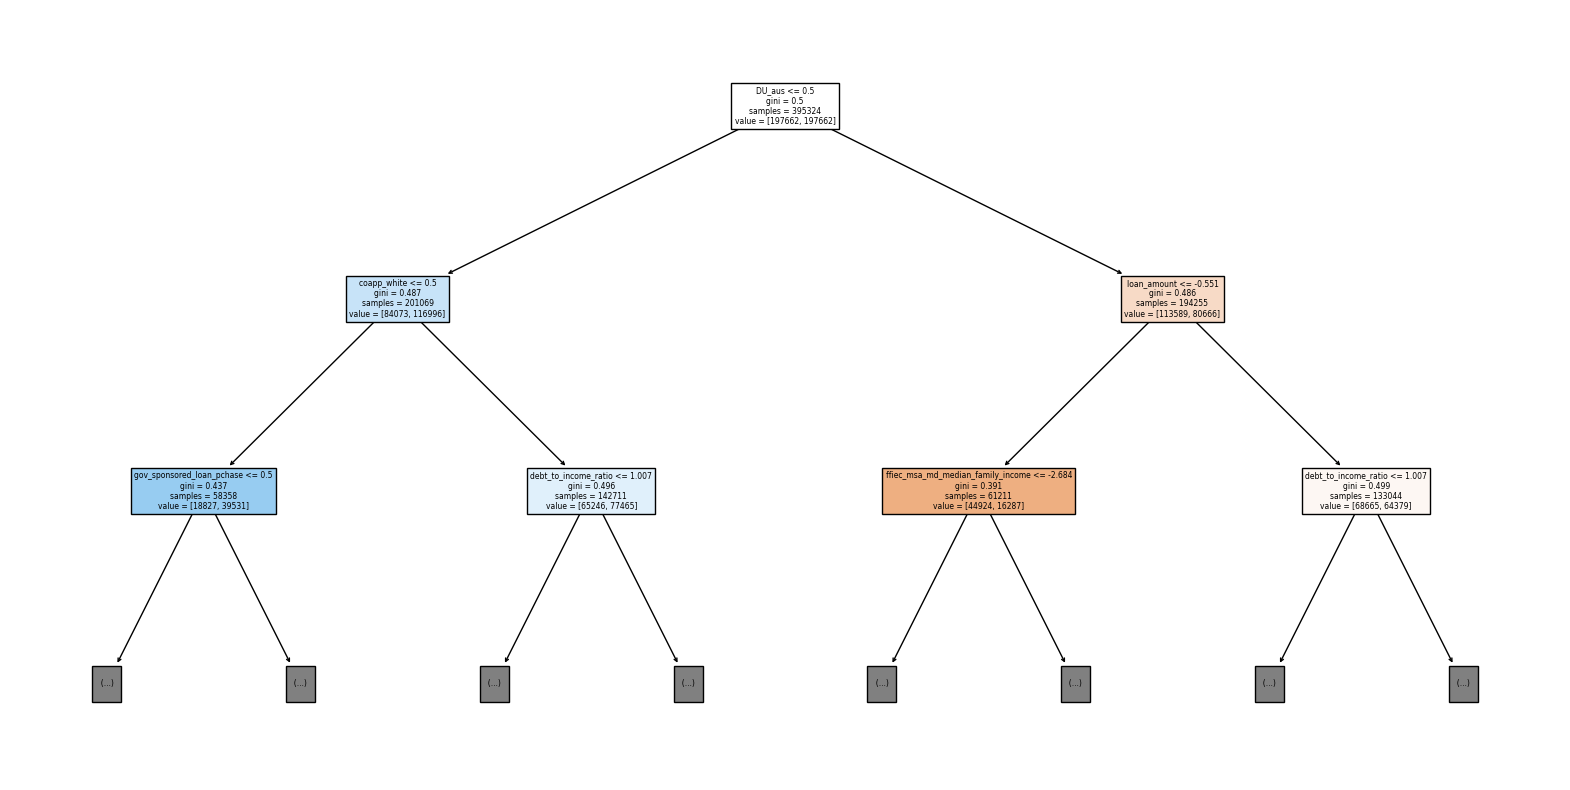

In [ ]:
_, axs = plt.subplots(figsize=(20,10))
cn=['with', 'without']
tree.plot_tree(model_DT, feature_names=X_train.columns,filled=True, ax=axs, max_depth=2)
plt.show()

### Logistics Regression analysis

In [ ]:
model_LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           loan_outcome   No. Observations:               395324
Model:                          Logit   Df Residuals:                   395283
Method:                           MLE   Df Model:                           40
Date:                Mon, 28 Nov 2022   Pseudo R-squ.:                  0.6164
Time:                        21:09:38   Log-Likelihood:            -1.0512e+05
converged:                       True   LL-Null:                   -2.7402e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
loan_amount                           0.0488      0.014      3.429      0.001       0.021       0.077
combined_loan_to_value_ratio         -0.0655      0.006    -10.571      0.000      -0.078      -0.053
loan_term                            -0.0460      0.005     -8.636      0.000      -0.056      -0.036
property_value                        0.0013      0.014      0.097      0.922      -0.025       0.028
income                               -0.1828      0.148     -1.238      0.216      -0.472       0.107
debt_to_income_ratio                 -0.6462      0.006   -112.199      0.000      -0.657      -0.635
tract_population                      0.0244      0.011      2.267      0.023       0.003       0.045
tract_minority_population_percent    -0.0525      0.007     -7.416      0.000      -0.066      -0.039
ffiec_msa_md_median_family_income     0.2509      0.007     38.440      0.000       0.238       0.264
tract_to_msa_income_percentage        0.1068      0.006     17.738      0.000       0.095       0.119
tract_one_to_four_family_homes        0.0558      0.010      5.461      0.000       0.036       0.076
tract_median_age_of_housing_units     0.1033      0.006     16.779      0.000       0.091       0.115
Nonconforming                        -0.7054      0.022    -32.433      0.000      -0.748      -0.663
Undetermined                         24.9488      0.703     35.484      0.000      23.571      26.327
gov_sponsored_loan_pchase           -10.4405      0.277    -37.625      0.000     -10.984      -9.897
banks_mtg_loan_pchase               -10.0475      0.378    -26.574      0.000     -10.789      -9.306
othr_loan_pchase                     -8.3884      0.317    -26.494      0.000      -9.009      -7.768
coapp_white                          -0.1221      0.021     -5.919      0.000      -0.162      -0.082
coapp_black                           0.2126      0.050      4.289      0.000       0.115       0.310
coapp_latino                          0.1875      0.033      5.668      0.000       0.123       0.252
coapp_asian                           0.1676      0.033      5.110      0.000       0.103       0.232
coapp_native                          0.3805      0.134      2.839      0.005       0.118       0.643
coapp_pac_islander                    0.5644      0.221      2.555      0.011       0.131       0.997
coapp_female                         -0.2449      0.021    -11.675      0.000      -0.286      -0.204
subord_lien_loan_sec                 -0.1917      0.034     -5.720      0.000      -0.257      -0.126
open_end_line_credit                  0.5655      0.035     15.990      0.000       0.496       0.635
FICO_credit_check                    -0.3981      0.020    -19.516      0.000      -0.438      -0.358
vantage_credit_check                  0.0965      0.046      2.094      0.036       0.006       0.187
other_credit_check                   -0.3961      0.039    -10.124      0.000  

In [ ]:
model_odds = pd.DataFrame(np.exp(model_LR.params), columns=['odds_ratio'])
model_odds.reset_index(names='features', inplace=True)

features = ['black', 'native', 'latino', 'asian', 'pac_islander']

model_odds[model_odds['features'].isin(features)].sort_values(by='odds_ratio', ascending=False)


features  odds_ratio
38        native    1.747992
35         black    1.623076
39  pac_islander    1.595048
36        latino    1.315157
37         asian    1.108136

### EBM Model Interpretation

In [ ]:

ebm_global = model_EB.explain_global()
show(ebm_global)

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\interpret\visual\udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\interpret\visual\udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\interpret\visual\udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you

<!-- http://127.0.0.1:7001/2989785486992/ -->

In [ ]:
y_test_bal.value_counts()

1    49416
0    49416
Name: loan_outcome, dtype: int64

In [ ]:
y_test_denied = y_test_bal[y_test_bal==0]
X_test_denied = X_test_std.loc[X_test_std.index.isin(y_test_denied.index)]
print(X_test_denied.shape, y_test_denied.shape)

(49416, 41) (49416,)


In [ ]:
ebm_local = model_EB.explain_local(X_test_denied[:50], y_test_denied[:50]) #X_test_std,y_test_bal
show(ebm_local)

C:\Users\danie\AppData\Local\Temp\ipykernel_13328\1070762766.py:1: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



<!-- http://127.0.0.1:7001/2989717124912/ -->

### Interpreting the Multilayer Perceptron with LIME

In [ ]:
from lime import lime_tabular

In [ ]:
X_test_denied.iloc[[1,3,8, 13],]


loan_amount  combined_loan_to_value_ratio  loan_term  property_value  \
2284178     1.288384                      0.533754   0.348497        0.801953   
3117810    -0.880467                      0.213039  -2.798845       -0.825676   
114483     -0.570631                     -0.428391   0.348497       -0.529744   
2987389    -0.477680                      1.175183   0.348497       -0.572020   

           income  debt_to_income_ratio  tract_population  \
2284178  0.044020             -0.455715         -0.143457   
3117810 -0.268763             -1.461490         -1.064908   
114483  -0.177955              2.020039         -0.422747   
2987389 -0.127506             -0.455715         -1.603974   

         tract_minority_population_percent  ffiec_msa_md_median_family_income  \
2284178                           0.353496                           1.608231   
3117810                           2.624798                           0.892839   
114483                            2.535566                           0.141452   
2987389                          -1.206305                          -3.597485   

         tract_to_msa_income_percentage  ...  coapp_other_credit_check  \
2284178                       -0.717088  ...                       1.0   
3117810                       -1.470715  ...                       1.0   
114483                        -1.847529  ...                       1.0   
2987389                       -2.349947  ...                       1.0   

         DU_aus  LP_aus  tech_open_aus  black  latino  asian  native  \
2284178     0.0     1.0            1.0    1.0     1.0    0.0     1.0   
3117810     1.0     1.0            1.0    1.0     0.0    1.0     1.0   
114483      0.0     1.0            1.0    0.0     1.0    1.0     1.0   
2987389     1.0     1.0            1.0    1.0     1.0    1.0     0.0   

         pac_islander  female  
2284178           1.0     1.0  
3117810           1.0     1.0  
114483            1.0     1.0  
2987389           1.0     0.0  

[4 rows x 41 columns]

In [ ]:
# %% Apply lime
# Initilize Lime for Tabular data
lime = LimeTabular(predict_fn=model_ML.predict_proba, 
                   data=X_test_std, 
                   #feature_names= X.columns,
                   random_state=1)
# Get local explanations
lime_local = lime.explain_local(X_test_denied.iloc[[1, 3, 8, 13],],
                                y_test_denied.iloc[[1, 3, 8, 13],],
                                name='LIME')

show(lime_local)

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPCl

<!-- http://127.0.0.1:7001/2989717124288/ -->

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(X_train_std.to_numpy(), mode="classification", feature_names= X_train_std.columns)
explainer

In [ ]:
predictions = model_ML.predict(X_test_denied.iloc[[1, 3, 8, 13],])


In [ ]:
pred_denied=np.where(predictions==0)

In [ ]:
pred_denied


(array([0, 1, 2, 3], dtype=int64),)

In [ ]:
X_test_std_np = X_test_denied.iloc[[1, 3, 8, 13],].to_numpy()


In [ ]:
for x in range(4):
  explanation = explainer.explain_instance(X_test_std_np[pred_denied[0][x]], model_ML.predict_proba, num_features=len(X.columns))
  explanation.show_in_notebook()
  explanation.save_to_file('LIME_'+str(x)+'.html')


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



### Interpreting Random Forest with SHAP

In [68]:
import shap

In [69]:
y_test_denied = y_test_bal[y_test_bal == 0]
X_test_denied = X_test_std.loc[X_test_std.index.isin(y_test_denied.index)]
print(X_test_denied.shape, y_test_denied.shape)


(49416, 41) (49416,)


In [70]:
explainer = shap.TreeExplainer(model_RF)

In [71]:
model_RF.predict(X_test_denied.iloc[[1, 3, 8, 13],]).mean()


0.0

In [73]:
shap_values = explainer.shap_values(X_test_denied.iloc[[1, 3, 8, 13],])


In [74]:
explainer.expected_value


array([0.49996072, 0.50003928])

In [ ]:
# %% Investigating the values (classification problem)
# class 0 = contribution to class 1
# class 1 = contribution to class 2
print(shap_values[0].shape)
shap_values

Sample 1

In [77]:
shap.initjs()
# Force plot

shap.force_plot(explainer.expected_value[1],
                shap_values[1][0],
                X_test_denied.iloc[[1],])  # for values



In [78]:
shap.initjs()
# Force plot

shap.force_plot(explainer.expected_value[1],
                shap_values[1][1],
                X_test_denied.iloc[[3],])  # for values


In [79]:
shap.initjs()
# Force plot

shap.force_plot(explainer.expected_value[1],
                shap_values[1][2],
                X_test_denied.iloc[[8],])  # for values


In [80]:
shap.initjs()
# Force plot

shap.force_plot(explainer.expected_value[1],
                shap_values[1][3],
                X_test_denied.iloc[[13],])  # for values


In [139]:
shap_values = explainer.shap_values(X_test_denied.iloc[[1,3, 8, 13],])


In [143]:
shap_values[1][3]


array([ 2.54979707e-03,  8.62095935e-03,  9.27701942e-04, -6.73635974e-03,
       -6.88188747e-02,  4.56797073e-02, -7.52031835e-02,  3.47394637e-03,
       -6.95660100e-02, -3.20305200e-02, -6.50631515e-02, -1.83728920e-02,
       -3.05483880e-03, -2.09813928e-05, -1.24600981e-01, -4.79743052e-02,
       -1.30215921e-02,  1.44915040e-02,  2.14235496e-05, -2.51762554e-04,
        1.35251573e-05, -9.35763750e-06, -9.58595907e-07, -1.91385657e-03,
       -6.56615221e-05,  1.41201503e-03,  5.33354089e-04,  4.33409308e-05,
       -2.04299928e-04, -1.90973548e-03, -2.82566980e-06, -3.15667713e-06,
       -5.61720696e-03, -5.77345693e-03,  9.96695008e-06,  1.89206983e-03,
        9.41633869e-04,  1.96756223e-04, -9.41764282e-04, -5.13283953e-06,
        1.43546783e-04])

In [146]:
explainer.expected_value[2]


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
shap_values = explainer.shap_values(X_test_denied.iloc[[1],])


In [82]:
shap_value_plot = explainer.shap_values(X_test_denied.iloc[[1, 3, 8, 13],])


In [86]:
explainerer = shap.TreeExplainer(model_RF, X_test_denied.iloc[[1, 3, 8, 13],])


In [87]:
shap_values = explainerer(X_test_denied.iloc[[1, 3, 8, 13],])


: 

: 

In [84]:

shap_values = explainerer(X)
feature_names = [
    a + ": " + str(b) for a, b in zip(X.columns, np.abs(shap_values.values).mean(0).round(2))
]

shap.summary_plot(shap_values, X, max_display=X.shape[1],
                  feature_names=feature_names)


In [85]:
# %% >> Visualize global features
# Feature summary
feature_names = [
    a + ": " + str(b) for a, b in zip(X_test_denied.columns, np.abs(shap_value_plot.values).mean(0).round(2))
]
shap.summary_plot(shap_value_plot, X_test_denied.iloc[[1, 3, 8, 13],],
                  max_display=X_test_denied.shape[1],
                  feature_names=feature_names)


AttributeError: 'list' object has no attribute 'values'

In [ ]:
shap.dependence_plot(column(black?), shap_values, X)